In [2]:
# Input data
import numpy as np
from utilities import *

# test and train read
Xtrain, Ytrain, _ = read_data(data_path='/home/arasdar/datasets/har/har-data/', split='train')
Xtest, Ytest, _ = read_data(data_path='/home/arasdar/datasets/har/har-data/', split='test')

# assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Ytrain.max(axis=0) == Ytest.max(axis=0), 'Mismatch in channels of Ytrain and Ytest'

# balanced data or not
print(np.mean(Ytrain==1), np.mean(Ytrain==2), np.mean(Ytrain==3), 
      np.mean(Ytrain==4), np.mean(Ytrain==5), np.mean(Ytrain==6))

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125
(7352, 128, 9) float64 (2947, 128, 9) float64
(7352,) int64 (2947,) int64


In [3]:
# Normalizing/standardizing the input data features
Xtrain, Xtest = standardize(train=Xtrain, test=Xtest)

Ytrain = one_hot(labels=Ytrain.reshape(-1), n_class=Ytrain.max(axis=0)) 
Ytest = one_hot(labels=Ytest.reshape(-1), n_class=Ytest.max(axis=0)) 

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

(7352, 128, 9) float64 (2947, 128, 9) float64
(7352, 6) float64 (2947, 6) float64


In [4]:
# Train and valid split
from sklearn.model_selection import train_test_split

Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype, Xvalid.shape, Xvalid.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype, Yvalid.shape, Yvalid.dtype)

(5146, 128, 9) float64 (2947, 128, 9) float64 (2206, 128, 9) float64
(5146, 6) float64 (2947, 6) float64 (2206, 6) float64


In [5]:
assert Xvalid.shape[0]==Yvalid.shape[0], 'batch_size or N for Xvalid and Yvalid are not equal.'

# Input data: NxWxCin
batch_size = Xvalid.shape[0]
seq_len = Xvalid.shape[1]
n_channels = Xvalid.shape[2]
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels: NxCout
batch_size = Yvalid.shape[0]
n_classes = Yvalid.shape[1]
print('bach_size, n_classes', batch_size, n_classes)

batch_size, seq_len, n_channels 2206 128 9
bach_size, n_classes 2206 6


In [6]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [7]:
# Feed the data from python/numpy to tensorflow framework
Xinput = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, n_channels], name=None)
Ylabels = tf.placeholder(dtype=tf.float32, shape=[batch_size, n_classes], name=None)
print(Xinput.shape, Xinput.dtype)
print(Ylabels.shape, Ylabels.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [8]:
# # Xinput NxWxCin => WxNxCin == (seq_len, N, n_channels)
print(Xinput.shape, Xinput.dtype)

lstm_in = tf.transpose(Xinput, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape, lstm_in.dtype)

lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape, lstm_in.dtype)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(value=lstm_in, num_or_size_splits=seq_len, axis=0)
print(len(lstm_in), lstm_in[0].shape, lstm_in[0].dtype)

(2206, 128, 9) <dtype: 'float32'>
(128, 2206, 9) <dtype: 'float32'>
(282368, 9) <dtype: 'float32'>
128 (2206, 9) <dtype: 'float32'>


In [9]:
# RNN-LSTM parameters
lstm_size = 3 * n_channels # 3 times the amount of channels
print(lstm_size)

# Add LSTM layers
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm = tf.nn.rnn_cell.BasicLSTMCell(num_units=lstm_size)

# drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
lstm_layers = 1 # Number of layers
cell = tf.nn.rnn_cell.MultiRNNCell(cells=[lstm] * lstm_layers)

initial_state = cell.zero_state(batch_size=batch_size, dtype=tf.float32)

27


In [10]:
outputs, final_state = tf.nn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32, initial_state=initial_state)
# print(outputs, final_state)

In [11]:
# We only need the last output tensor to pass into a classifier
Ylogits = tf.layers.dense(inputs=outputs[-1], units=n_classes, name=None)
print(Ylogits.shape, Ylogits.dtype)
print(len(outputs), outputs[-1].shape, outputs[-1].dtype)

(2206, 6) <dtype: 'float32'>
128 (2206, 27) <dtype: 'float32'>


In [13]:
# Backward pass: error backpropagation
# Cost function
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels)
print(loss)
loss = tf.reduce_mean(input_tensor=loss)
print(loss)

# Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss=loss)
print('optimizer', optimizer)

# Accuracy
Ylogits_argmax = tf.argmax(input=Ylogits, axis=1)
Ylabels_argmax = tf.argmax(input=Ylabels, axis=1)
print(Ylogits_argmax, Ylabels_argmax)
accuracy = tf.equal(x=Ylogits_argmax, y=Ylabels_argmax)
print(accuracy)
accuracy = tf.cast(x=accuracy, dtype=tf.float32)
print(accuracy)
accuracy = tf.reduce_mean(input_tensor=accuracy, name=None)
print(accuracy)

Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(2206,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/ApplyAdam"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

Tensor("ArgMax:0", shape=(2206,), dtype=int64) Tensor("ArgMax_1:0", shape=(2206,), dtype=int64)
Tensor("Equal:0", shape=(2206,), dtype=bool)
Tensor("Cast:0", shape=(2206,), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [17]:
# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

In [14]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    epochs = 1000
    for epoch in range(epochs):
        
        # Loop over batches of training
        state = sess.run(fetches=initial_state)
        loss_batch, acc_batch = [], []
        for Xarr, Yarr in get_batches(X=Xtrain, y=Ytrain, batch_size=batch_size):
            
            # Feed dictionary
            feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
            lossarr, _ , state, accarr = sess.run(fetches=[loss, optimizer, final_state, accuracy], 
                                                  feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        train_acc.append(np.mean(acc_batch))
        train_loss.append(np.mean(loss_batch))

        # Loop over batches of validation
        state = sess.run(initial_state)
        loss_batch, acc_batch = [], []
        for Xarr, Yarr in get_batches(X=Xvalid, y=Yvalid, batch_size=batch_size):
            
            # Feed dictionary
            feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
            lossarr, state, accarr = sess.run(fetches=[loss, final_state, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        valid_acc.append(np.mean(acc_batch))
        valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(epoch+1, epochs),
              "Train loss: {:6f}".format(train_loss[epoch]),
              "Valid loss: {:.6f}".format(valid_loss[epoch]),
              "Train acc: {:6f}".format(train_acc[epoch]),
              "Valid acc: {:.6f}".format(valid_acc[epoch]))
                
    saver.save(sess, 'checkpoints/lstm-imu-har.ckpt')

Epoch: 1/1000 Train loss: 1.778386 Valid loss: 1.764080 Train acc: 0.334542 Valid acc: 0.340889
Epoch: 2/1000 Train loss: 1.743969 Valid loss: 1.729560 Train acc: 0.357208 Valid acc: 0.354941
Epoch: 3/1000 Train loss: 1.711249 Valid loss: 1.696650 Train acc: 0.371487 Valid acc: 0.374887
Epoch: 4/1000 Train loss: 1.679941 Valid loss: 1.665096 Train acc: 0.394379 Valid acc: 0.417951
Epoch: 5/1000 Train loss: 1.649791 Valid loss: 1.634589 Train acc: 0.434950 Valid acc: 0.464189
Epoch: 6/1000 Train loss: 1.620479 Valid loss: 1.604738 Train acc: 0.475521 Valid acc: 0.503173
Epoch: 7/1000 Train loss: 1.591622 Valid loss: 1.575143 Train acc: 0.510879 Valid acc: 0.543971
Epoch: 8/1000 Train loss: 1.562842 Valid loss: 1.545457 Train acc: 0.547824 Valid acc: 0.576156
Epoch: 9/1000 Train loss: 1.533816 Valid loss: 1.515411 Train acc: 0.570943 Valid acc: 0.593382
Epoch: 10/1000 Train loss: 1.504290 Valid loss: 1.484810 Train acc: 0.582276 Valid acc: 0.600635
Epoch: 11/1000 Train loss: 1.474077 Val

Epoch: 86/1000 Train loss: 0.394824 Valid loss: 0.393208 Train acc: 0.886899 Valid acc: 0.890299
Epoch: 87/1000 Train loss: 0.389918 Valid loss: 0.387659 Train acc: 0.891206 Valid acc: 0.890299
Epoch: 88/1000 Train loss: 0.384560 Valid loss: 0.382772 Train acc: 0.892566 Valid acc: 0.892112
Epoch: 89/1000 Train loss: 0.379530 Valid loss: 0.379096 Train acc: 0.895286 Valid acc: 0.891659
Epoch: 90/1000 Train loss: 0.375687 Valid loss: 0.376132 Train acc: 0.898232 Valid acc: 0.890752
Epoch: 91/1000 Train loss: 0.371146 Valid loss: 0.372179 Train acc: 0.899365 Valid acc: 0.892112
Epoch: 92/1000 Train loss: 0.367079 Valid loss: 0.368162 Train acc: 0.899819 Valid acc: 0.892112
Epoch: 93/1000 Train loss: 0.362283 Valid loss: 0.363094 Train acc: 0.902539 Valid acc: 0.894832
Epoch: 94/1000 Train loss: 0.357599 Valid loss: 0.357023 Train acc: 0.903672 Valid acc: 0.898005
Epoch: 95/1000 Train loss: 0.352463 Valid loss: 0.353839 Train acc: 0.904578 Valid acc: 0.896645
Epoch: 96/1000 Train loss: 0.3

Epoch: 170/1000 Train loss: 0.167467 Valid loss: 0.165238 Train acc: 0.951723 Valid acc: 0.952403
Epoch: 171/1000 Train loss: 0.167729 Valid loss: 0.164977 Train acc: 0.951269 Valid acc: 0.953762
Epoch: 172/1000 Train loss: 0.166128 Valid loss: 0.162357 Train acc: 0.951723 Valid acc: 0.953309
Epoch: 173/1000 Train loss: 0.162409 Valid loss: 0.160518 Train acc: 0.953989 Valid acc: 0.951949
Epoch: 174/1000 Train loss: 0.163364 Valid loss: 0.157323 Train acc: 0.952856 Valid acc: 0.953309
Epoch: 175/1000 Train loss: 0.160940 Valid loss: 0.156731 Train acc: 0.953762 Valid acc: 0.955122
Epoch: 176/1000 Train loss: 0.160257 Valid loss: 0.155939 Train acc: 0.952856 Valid acc: 0.954669
Epoch: 177/1000 Train loss: 0.157637 Valid loss: 0.158506 Train acc: 0.955122 Valid acc: 0.951496
Epoch: 178/1000 Train loss: 0.159860 Valid loss: 0.164881 Train acc: 0.953083 Valid acc: 0.946510
Epoch: 179/1000 Train loss: 0.161585 Valid loss: 0.160308 Train acc: 0.951949 Valid acc: 0.950589
Epoch: 180/1000 Trai

Epoch: 255/1000 Train loss: 0.123666 Valid loss: 0.129978 Train acc: 0.959429 Valid acc: 0.954669
Epoch: 256/1000 Train loss: 0.123663 Valid loss: 0.128545 Train acc: 0.958976 Valid acc: 0.954669
Epoch: 257/1000 Train loss: 0.123455 Valid loss: 0.128414 Train acc: 0.958976 Valid acc: 0.955122
Epoch: 258/1000 Train loss: 0.123341 Valid loss: 0.128201 Train acc: 0.959656 Valid acc: 0.955122
Epoch: 259/1000 Train loss: 0.122611 Valid loss: 0.128140 Train acc: 0.959202 Valid acc: 0.955122
Epoch: 260/1000 Train loss: 0.122232 Valid loss: 0.129301 Train acc: 0.958976 Valid acc: 0.954669
Epoch: 261/1000 Train loss: 0.121921 Valid loss: 0.127806 Train acc: 0.959882 Valid acc: 0.955576
Epoch: 262/1000 Train loss: 0.121134 Valid loss: 0.125344 Train acc: 0.960109 Valid acc: 0.956936
Epoch: 263/1000 Train loss: 0.120924 Valid loss: 0.124062 Train acc: 0.960109 Valid acc: 0.957389
Epoch: 264/1000 Train loss: 0.120603 Valid loss: 0.123768 Train acc: 0.959429 Valid acc: 0.956936
Epoch: 265/1000 Trai

Epoch: 340/1000 Train loss: 0.115046 Valid loss: 0.113832 Train acc: 0.958296 Valid acc: 0.960562
Epoch: 341/1000 Train loss: 0.114346 Valid loss: 0.112411 Train acc: 0.957389 Valid acc: 0.960109
Epoch: 342/1000 Train loss: 0.112988 Valid loss: 0.112540 Train acc: 0.959882 Valid acc: 0.961922
Epoch: 343/1000 Train loss: 0.112302 Valid loss: 0.112204 Train acc: 0.961695 Valid acc: 0.961922
Epoch: 344/1000 Train loss: 0.111154 Valid loss: 0.113638 Train acc: 0.960562 Valid acc: 0.960562
Epoch: 345/1000 Train loss: 0.111237 Valid loss: 0.111703 Train acc: 0.960335 Valid acc: 0.962375
Epoch: 346/1000 Train loss: 0.110602 Valid loss: 0.112148 Train acc: 0.962149 Valid acc: 0.961922
Epoch: 347/1000 Train loss: 0.110762 Valid loss: 0.111406 Train acc: 0.962375 Valid acc: 0.962829
Epoch: 348/1000 Train loss: 0.108694 Valid loss: 0.113810 Train acc: 0.963962 Valid acc: 0.959202
Epoch: 349/1000 Train loss: 0.109956 Valid loss: 0.112211 Train acc: 0.961015 Valid acc: 0.959655
Epoch: 350/1000 Trai

Epoch: 424/1000 Train loss: 0.095853 Valid loss: 0.105304 Train acc: 0.963962 Valid acc: 0.961469
Epoch: 425/1000 Train loss: 0.095719 Valid loss: 0.105450 Train acc: 0.963962 Valid acc: 0.960562
Epoch: 426/1000 Train loss: 0.095656 Valid loss: 0.105428 Train acc: 0.963735 Valid acc: 0.961015
Epoch: 427/1000 Train loss: 0.095503 Valid loss: 0.105478 Train acc: 0.963962 Valid acc: 0.961015
Epoch: 428/1000 Train loss: 0.095391 Valid loss: 0.105468 Train acc: 0.963962 Valid acc: 0.961469
Epoch: 429/1000 Train loss: 0.095273 Valid loss: 0.105511 Train acc: 0.963962 Valid acc: 0.960562
Epoch: 430/1000 Train loss: 0.095199 Valid loss: 0.105497 Train acc: 0.963962 Valid acc: 0.961015
Epoch: 431/1000 Train loss: 0.095089 Valid loss: 0.105515 Train acc: 0.963962 Valid acc: 0.961015
Epoch: 432/1000 Train loss: 0.094981 Valid loss: 0.105529 Train acc: 0.963962 Valid acc: 0.960562
Epoch: 433/1000 Train loss: 0.094877 Valid loss: 0.105558 Train acc: 0.963962 Valid acc: 0.960562
Epoch: 434/1000 Trai

Epoch: 508/1000 Train loss: 0.096784 Valid loss: 0.110028 Train acc: 0.962375 Valid acc: 0.957389
Epoch: 509/1000 Train loss: 0.095945 Valid loss: 0.110561 Train acc: 0.963055 Valid acc: 0.959655
Epoch: 510/1000 Train loss: 0.095978 Valid loss: 0.108727 Train acc: 0.963055 Valid acc: 0.958296
Epoch: 511/1000 Train loss: 0.095106 Valid loss: 0.109951 Train acc: 0.963735 Valid acc: 0.959202
Epoch: 512/1000 Train loss: 0.095695 Valid loss: 0.107259 Train acc: 0.963509 Valid acc: 0.958749
Epoch: 513/1000 Train loss: 0.094481 Valid loss: 0.109424 Train acc: 0.963962 Valid acc: 0.960109
Epoch: 514/1000 Train loss: 0.094989 Valid loss: 0.106433 Train acc: 0.963735 Valid acc: 0.959655
Epoch: 515/1000 Train loss: 0.094073 Valid loss: 0.107898 Train acc: 0.964415 Valid acc: 0.960109
Epoch: 516/1000 Train loss: 0.094203 Valid loss: 0.105589 Train acc: 0.963735 Valid acc: 0.959202
Epoch: 517/1000 Train loss: 0.091931 Valid loss: 0.107374 Train acc: 0.964642 Valid acc: 0.960562
Epoch: 518/1000 Trai

Epoch: 592/1000 Train loss: 0.085640 Valid loss: 0.108863 Train acc: 0.968948 Valid acc: 0.962829
Epoch: 593/1000 Train loss: 0.085718 Valid loss: 0.108739 Train acc: 0.968722 Valid acc: 0.963282
Epoch: 594/1000 Train loss: 0.085461 Valid loss: 0.109231 Train acc: 0.968268 Valid acc: 0.963282
Epoch: 595/1000 Train loss: 0.085315 Valid loss: 0.108630 Train acc: 0.968042 Valid acc: 0.962829
Epoch: 596/1000 Train loss: 0.085224 Valid loss: 0.109429 Train acc: 0.968722 Valid acc: 0.963282
Epoch: 597/1000 Train loss: 0.085403 Valid loss: 0.108929 Train acc: 0.968042 Valid acc: 0.963282
Epoch: 598/1000 Train loss: 0.085119 Valid loss: 0.108529 Train acc: 0.968042 Valid acc: 0.963282
Epoch: 599/1000 Train loss: 0.084982 Valid loss: 0.109490 Train acc: 0.967815 Valid acc: 0.964189
Epoch: 600/1000 Train loss: 0.085053 Valid loss: 0.109534 Train acc: 0.968268 Valid acc: 0.962829
Epoch: 601/1000 Train loss: 0.085019 Valid loss: 0.109287 Train acc: 0.968495 Valid acc: 0.962829
Epoch: 602/1000 Trai

Epoch: 677/1000 Train loss: 0.082492 Valid loss: 0.107664 Train acc: 0.971668 Valid acc: 0.963282
Epoch: 678/1000 Train loss: 0.082978 Valid loss: 0.107840 Train acc: 0.970082 Valid acc: 0.962829
Epoch: 679/1000 Train loss: 0.082336 Valid loss: 0.107269 Train acc: 0.971895 Valid acc: 0.962375
Epoch: 680/1000 Train loss: 0.082388 Valid loss: 0.108054 Train acc: 0.971895 Valid acc: 0.962829
Epoch: 681/1000 Train loss: 0.082090 Valid loss: 0.107685 Train acc: 0.972121 Valid acc: 0.963282
Epoch: 682/1000 Train loss: 0.082580 Valid loss: 0.108164 Train acc: 0.970308 Valid acc: 0.962829
Epoch: 683/1000 Train loss: 0.082181 Valid loss: 0.108128 Train acc: 0.971215 Valid acc: 0.961469
Epoch: 684/1000 Train loss: 0.082196 Valid loss: 0.108432 Train acc: 0.970762 Valid acc: 0.961922
Epoch: 685/1000 Train loss: 0.082078 Valid loss: 0.107997 Train acc: 0.971668 Valid acc: 0.962375
Epoch: 686/1000 Train loss: 0.082114 Valid loss: 0.108348 Train acc: 0.969628 Valid acc: 0.962375
Epoch: 687/1000 Trai

Epoch: 761/1000 Train loss: 0.079691 Valid loss: 0.112573 Train acc: 0.972801 Valid acc: 0.961015
Epoch: 762/1000 Train loss: 0.079592 Valid loss: 0.112247 Train acc: 0.973708 Valid acc: 0.961922
Epoch: 763/1000 Train loss: 0.079477 Valid loss: 0.112062 Train acc: 0.974161 Valid acc: 0.961469
Epoch: 764/1000 Train loss: 0.079253 Valid loss: 0.112144 Train acc: 0.973028 Valid acc: 0.961015
Epoch: 765/1000 Train loss: 0.079232 Valid loss: 0.114083 Train acc: 0.974161 Valid acc: 0.961015
Epoch: 766/1000 Train loss: 0.079001 Valid loss: 0.114523 Train acc: 0.973935 Valid acc: 0.961922
Epoch: 767/1000 Train loss: 0.079048 Valid loss: 0.114288 Train acc: 0.973935 Valid acc: 0.961015
Epoch: 768/1000 Train loss: 0.078709 Valid loss: 0.114404 Train acc: 0.973481 Valid acc: 0.960562
Epoch: 769/1000 Train loss: 0.078774 Valid loss: 0.114346 Train acc: 0.974161 Valid acc: 0.960562
Epoch: 770/1000 Train loss: 0.078727 Valid loss: 0.113523 Train acc: 0.974161 Valid acc: 0.960562
Epoch: 771/1000 Trai

Epoch: 845/1000 Train loss: 0.084053 Valid loss: 0.122514 Train acc: 0.972121 Valid acc: 0.959655
Epoch: 846/1000 Train loss: 0.087002 Valid loss: 0.129981 Train acc: 0.970762 Valid acc: 0.959655
Epoch: 847/1000 Train loss: 0.089539 Valid loss: 0.130766 Train acc: 0.969628 Valid acc: 0.957842
Epoch: 848/1000 Train loss: 0.089413 Valid loss: 0.120904 Train acc: 0.969175 Valid acc: 0.959202
Epoch: 849/1000 Train loss: 0.089956 Valid loss: 0.119093 Train acc: 0.969175 Valid acc: 0.959655
Epoch: 850/1000 Train loss: 0.101321 Valid loss: 0.118743 Train acc: 0.967815 Valid acc: 0.961469
Epoch: 851/1000 Train loss: 0.099551 Valid loss: 0.112905 Train acc: 0.968495 Valid acc: 0.959655
Epoch: 852/1000 Train loss: 0.094229 Valid loss: 0.112838 Train acc: 0.967362 Valid acc: 0.961922
Epoch: 853/1000 Train loss: 0.088729 Valid loss: 0.116822 Train acc: 0.969402 Valid acc: 0.957842
Epoch: 854/1000 Train loss: 0.091411 Valid loss: 0.117775 Train acc: 0.967362 Valid acc: 0.957842
Epoch: 855/1000 Trai

Epoch: 929/1000 Train loss: 0.077817 Valid loss: 0.113780 Train acc: 0.974161 Valid acc: 0.961015
Epoch: 930/1000 Train loss: 0.078217 Valid loss: 0.111510 Train acc: 0.975295 Valid acc: 0.962375
Epoch: 931/1000 Train loss: 0.078616 Valid loss: 0.113047 Train acc: 0.974161 Valid acc: 0.960109
Epoch: 932/1000 Train loss: 0.077331 Valid loss: 0.110330 Train acc: 0.975521 Valid acc: 0.963282
Epoch: 933/1000 Train loss: 0.078894 Valid loss: 0.112570 Train acc: 0.974161 Valid acc: 0.960562
Epoch: 934/1000 Train loss: 0.077407 Valid loss: 0.109660 Train acc: 0.975068 Valid acc: 0.963282
Epoch: 935/1000 Train loss: 0.077906 Valid loss: 0.112705 Train acc: 0.974388 Valid acc: 0.960562
Epoch: 936/1000 Train loss: 0.077539 Valid loss: 0.110562 Train acc: 0.975068 Valid acc: 0.961922
Epoch: 937/1000 Train loss: 0.077487 Valid loss: 0.111284 Train acc: 0.973708 Valid acc: 0.962375
Epoch: 938/1000 Train loss: 0.077136 Valid loss: 0.110831 Train acc: 0.974388 Valid acc: 0.962829
Epoch: 939/1000 Trai

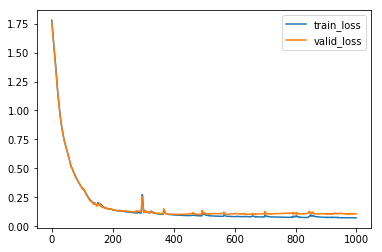

In [19]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

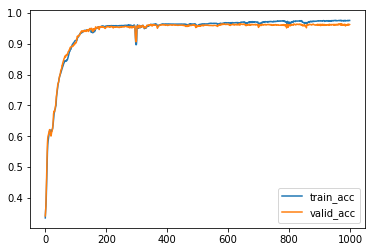

In [20]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [21]:
with tf.Session() as sess:
    # Restore the validated model
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    saver.restore(sess=sess, save_path='checkpoints/lstm-imu-har.ckpt')
    
    # Loop over batches of Test
    state = sess.run(fetches=initial_state)
    loss_batch, acc_batch = [], []
    for Xarr, Yarr in get_batches(X=Xtest, y=Ytest, batch_size=batch_size):

        # Feed dictionary
        feed_dict = {Xinput:Xarr, Ylabels:Yarr, initial_state:state}
        lossarr, state, accarr = sess.run(fetches=[loss, final_state, accuracy], feed_dict=feed_dict)
        loss_batch.append(lossarr)
        acc_batch.append(accarr)

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:.6f}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/lstm-imu-har.ckpt
Test loss: 0.535821 Test acc: 0.881233
